In [191]:
# Data manipulation
import pandas as pd
import numpy as np
# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 18
%matplotlib inline
MAX_EVALS = 100
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
import json
import shlex
import subprocess
import logging
from pprint import pprint
import re
import os


In [192]:
file_suffix = "temp" + str(MAX_EVALS)
def runthebenchmark(hyperparameters):
    os.chdir('/home/meghaagr/project/progress/active/../')
    storeinfile(hyperparameters)
    out=subprocess.Popen(["python3","read_config_general.py","-n 8","-c200 200 400 4 4 4 1"], shell=False, stdout=subprocess.PIPE)
    logging.basicConfig(level=logging.DEBUG)
    output=out.stdout.read().decode('utf-8')
    print("output"+output)
    if len(output.split(" ")) > 5:
        values = output.split(" ")
        value = float(float(values[6])*1024)/float(values[5]) + float(float(values[3])*1024)/float(values[2])
        value = float(value)
        print(value)
        return float((value/100)**3),output
    return 0,0

In [193]:
import json
from sklearn.externals import joblib
import os
os.chdir('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active')


# Loading the model and scaler
filename="btiofinalxgb.sav"
loaded_model = joblib.load(open(filename, 'rb'))
scaler_filename = "btioscalerxgb.save"
scaler = joblib.load(scaler_filename) 

In [194]:
def runfromsavedmodel(hyperparameters):
### INITIALIZE THIS MANUALLY ####
    nx_g = 200
    ny_g = 300
    nz_g = 400
    processes= 8
   # Active learning model choosees and saves the values of parameters
    storeinfile(hyperparameters)
    with open('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active/confex.json') as f:
        data = json.load(f)

    romio_ds_read = data["mpi"]["romio_ds_read"] == "enable"
    romio_ds_write = data["mpi"]["romio_ds_write"] == "enable"
    romio_cb_read = data["mpi"]["romio_cb_read"] == "enable"
    romio_cb_write = data["mpi"]["romio_cb_write"] == "enable"
    cb_buffer_size = data["mpi"]["cb_buffer_size"]
    stripe_size = data["lfs"]["setstripe"]["size"]
    stripe_count = data["lfs"]["setstripe"]["count"]
    col_names =  ['cb5','cb6','cb7','cb8','cb8','cb10','cb11']
    cb_df  = pd.DataFrame(columns = col_names)
    cb_df.loc[len(cb_df)] = [romio_ds_read, romio_ds_write, romio_cb_read,romio_cb_write,stripe_size, stripe_count, cb_buffer_size]


    col_names =  ['0','1', '2','3']
    my_df = pd.DataFrame(columns=col_names)
    

    my_df.loc[len(my_df)] = [nx_g,ny_g,nz_g,processes]
    x = pd.concat([my_df,cb_df], axis=1)
    #normalize the test data
    norm_df = pd.DataFrame(scaler.transform(x))
    out = loaded_model.predict(norm_df)
    return float(1/float(out[0])),0
    

In [195]:
# # Import section
# import pickle
# import json
# from sklearn.externals import joblib
# import os
# os.chdir('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active')


# # Loading the model and scaler
# filename="final.sav"
# loaded_model = pickle.load(open(filename, 'rb'))
# scaler_filename = "scaler.save"
# scaler = joblib.load(scaler_filename) 


In [196]:
# def runfromsavedmodel(hyperparameters):
#    # Active learning model choosees and saves the values of parameters
#     storeinfile(hyperparameters)
#     with open('/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active/confex.json') as f:
#         data = json.load(f)

#     cb_buffer_size = data["mpi"]["cb_buffer_size"]
#     stripe_size = data["lfs"]["setstripe"]["size"]
#     stripe_count = data["lfs"]["setstripe"]["count"]
#     col_names =  ['cb1', 'cb2', 'cb3']
#     cb_df  = pd.DataFrame(columns = col_names)
#     cb_df.loc[len(cb_df)] = [stripe_size, stripe_count, cb_buffer_size]

#     #normalize the test data
#     norm_df = scaler.transform( cb_df )
#     temp = pd.DataFrame(norm_df)

#     col_names =  ['0','1', '2','3','4','5']
#     my_df = pd.DataFrame(columns=col_names)
    
#     ### INITIALIZE THIS MANUALLY ####
#     my_df.loc[len(my_df)] = [300,300,300,2,2,4]
#     x = pd.concat([my_df,temp], axis=1)
#     out = loaded_model.predict(x)
#     return float(1/float(out[0])),0
    

In [197]:
def storeinfile(hyperparameters):
    data={"mpi": {"romio_ds_read": "enable", "romio_ds_write": "disable"}, "lfs": {"setstripe": {"size": "16777216", "count": 4}}}
    data["lfs"]["setstripe"]["size"] = int(hyperparameters["setstripe-size"])
    data["lfs"]["setstripe"]["count"] = int(hyperparameters["setstripe-count"])

    data["mpi"]["romio_ds_read"] = hyperparameters["romio_ds_read"]
    data["mpi"]["romio_ds_write"] = hyperparameters["romio_ds_write"]
    data["mpi"]["romio_cb_read"] = hyperparameters["romio_cb_read"]
    data["mpi"]["romio_cb_write"] = hyperparameters["romio_cb_write"]
    data["mpi"]["cb_buffer_size"] = str(int(hyperparameters["cb_buffer_size"]))
    with open("/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active/confex.json","w") as fp:
        json.dump(data,fp)
    print(data)


In [198]:
def objective(hyperparameters):
    global ITERATION
    ITERATION += 1
    start = timer()
    result=0
    while(result == 0):
        print("rerun")
        result,output = runfromsavedmodel(hyperparameters)
        print(result)
    run_time = timer() - start
    print({'loss': result, 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK})
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([float(result), hyperparameters, ITERATION, run_time, output])
    return {'loss': float(result), 'hyperparameters': hyperparameters, 'iteration': ITERATION, 'iteration_time': run_time, 'status': STATUS_OK}

In [199]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

space = {
    'romio_ds_read' : hp.choice('romio_ds_read',['enable','disable']),
    'romio_ds_write' : hp.choice('romio_ds_write',['enable','disable']),
    'romio_cb_read' : hp.choice('romio_cb_read',['enable','disable']),
    'romio_cb_write' : hp.choice('romio_cb_write',['enable','disable']),
    'cb_buffer_size' : 1048576*hp.quniform('cb_buffer_size',1,512,1),
    'setstripe-size' : 65536*(hp.quniform('setstripe-size',0,512,1)),
    'setstripe-count' : hp.qloguniform('setstripe-count',0,5,1)
    
}

In [200]:
x = sample(space)
params = x
print(x)

cb_buffer_size_dist = []
for _ in range(1000):
    cb_buffer_size_dist.append(sample(space)['cb_buffer_size'])
    
setstripe_size_dist = []
for _ in range(1000):
    setstripe_size_dist.append(sample(space)['setstripe-size'])
    
setstripe_count_dist = []
for _ in range(1000):
    setstripe_count_dist.append(sample(space)['setstripe-count']) 
    
romio_ds_read_dist = []
for _ in range(20):
    romio_ds_read_dist.append(sample(space)['romio_ds_read'])
    
romio_ds_write_dist = []
for _ in range(20):
    romio_ds_write_dist.append(sample(space)['romio_ds_write'])
    
romio_cb_read_dist = []
for _ in range(20):
    romio_cb_read_dist.append(sample(space)['romio_cb_read']) 
    
romio_cb_write_dist = []
for _ in range(20):
    romio_cb_write_dist.append(sample(space)['romio_cb_write']) 
    

{'cb_buffer_size': 432013312.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'setstripe-count': 1.0, 'setstripe-size': 32833536.0}


In [201]:
# File to save first results
print(os.getcwd())
out_file = '/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active/result/gbm_trials-'+file_suffix+'.csv'

of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time', 'output'])
of_connection.close()

/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active


In [202]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest


from hyperopt import Trials

# Record results
bayes_trials = Trials()

from hyperopt import fmin


ITERATION = 1

best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = bayes_trials, max_evals = MAX_EVALS)

rerun                                                
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'cb_buffer_size': '454033408'}, 'lfs': {'setstripe': {'size': 7274496, 'count': 142}}}
0.01917697124793037                                  
{'loss': 0.01917697124793037, 'hyperparameters': {'cb_buffer_size': 454033408.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'disable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 142.0, 'setstripe-size': 7274496.0}, 'iteration': 2, 'iteration_time': 0.0807183899996744, 'status': 'ok'}
rerun                                                
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '140509184'}, 'lfs': {'setstripe': {'size': 4784128, 'count': 31}}}
0.040867661434660016                                                           
{'loss': 0.0408676614346

rerun                                                                             
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '520093696'}, 'lfs': {'setstripe': {'size': 7798784, 'count': 2}}}
0.0015768375802434108                                                             
{'loss': 0.0015768375802434108, 'hyperparameters': {'cb_buffer_size': 520093696.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'setstripe-count': 2.0, 'setstripe-size': 7798784.0}, 'iteration': 14, 'iteration_time': 0.04221012400012114, 'status': 'ok'}
rerun                                                                             
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '436207616'}, 'lfs': {'setstripe': {'size': 2293760, 'count': 12}}}
0.001528592203340

rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '349175808'}, 'lfs': {'setstripe': {'size': 9437184, 'count': 24}}}
0.001415945478493902                                                             
{'loss': 0.001415945478493902, 'hyperparameters': {'cb_buffer_size': 349175808.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 24.0, 'setstripe-size': 9437184.0}, 'iteration': 26, 'iteration_time': 0.04827526100052637, 'status': 'ok'}
rerun                                                                            
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '178257920'}, 'lfs': {'setstripe': {'size': 393216, 'count': 5}}}
0.0013652296896460

rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '168820736'}, 'lfs': {'setstripe': {'size': 9175040, 'count': 1}}}
0.0014153834139248363                                                           
{'loss': 0.0014153834139248363, 'hyperparameters': {'cb_buffer_size': 168820736.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 1.0, 'setstripe-size': 9175040.0}, 'iteration': 38, 'iteration_time': 0.04857240300043486, 'status': 'ok'}
rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '201326592'}, 'lfs': {'setstripe': {'size': 4325376, 'count': 6}}}
0.038585644428128965

rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '279969792'}, 'lfs': {'setstripe': {'size': 7012352, 'count': 12}}}
0.001449270490804156                                                            
{'loss': 0.001449270490804156, 'hyperparameters': {'cb_buffer_size': 279969792.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 12.0, 'setstripe-size': 7012352.0}, 'iteration': 50, 'iteration_time': 0.04425857800015365, 'status': 'ok'}
rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '82837504'}, 'lfs': {'setstripe': {'size': 2555904, 'count': 59}}}
0.002113367650189669

rerun                                                                           
{'mpi': {'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'cb_buffer_size': '213909504'}, 'lfs': {'setstripe': {'size': 31129600, 'count': 6}}}
0.001512110078365031                                                            
{'loss': 0.001512110078365031, 'hyperparameters': {'cb_buffer_size': 213909504.0, 'romio_cb_read': 'enable', 'romio_cb_write': 'enable', 'romio_ds_read': 'enable', 'romio_ds_write': 'enable', 'setstripe-count': 6.0, 'setstripe-size': 31129600.0}, 'iteration': 62, 'iteration_time': 0.04165608100083773, 'status': 'ok'}
rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '396361728'}, 'lfs': {'setstripe': {'size': 1441792, 'count': 4}}}
0.001470385780622821      

rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '68157440'}, 'lfs': {'setstripe': {'size': 19988480, 'count': 7}}}
0.001985135113440403                                                            
{'loss': 0.001985135113440403, 'hyperparameters': {'cb_buffer_size': 68157440.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 7.0, 'setstripe-size': 19988480.0}, 'iteration': 74, 'iteration_time': 0.040510438997444, 'status': 'ok'}
rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '114294784'}, 'lfs': {'setstripe': {'size': 13565952, 'count': 9}}}
0.001488164712511901   

rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '303038464'}, 'lfs': {'setstripe': {'size': 6946816, 'count': 14}}}
0.019815399249560085                                                            
{'loss': 0.019815399249560085, 'hyperparameters': {'cb_buffer_size': 303038464.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 14.0, 'setstripe-size': 6946816.0}, 'iteration': 86, 'iteration_time': 0.03629907399954391, 'status': 'ok'}
rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'enable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '161480704'}, 'lfs': {'setstripe': {'size': 15466496, 'count': 39}}}
0.001412628366481

rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '253755392'}, 'lfs': {'setstripe': {'size': 32833536, 'count': 26}}}
0.0015634832008577782                                                           
{'loss': 0.0015634832008577782, 'hyperparameters': {'cb_buffer_size': 253755392.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 26.0, 'setstripe-size': 32833536.0}, 'iteration': 98, 'iteration_time': 0.07883959300306742, 'status': 'ok'}
rerun                                                                           
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'disable', 'cb_buffer_size': '121634816'}, 'lfs': {'setstripe': {'size': 17039360, 'count': 1}}}
0.0258053389283

In [203]:
print(best)
d=  best
#print(bayes_trials.results)
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
#bayes_trials_results[:1]

{'cb_buffer_size': 135.0, 'romio_cb_read': 1, 'romio_cb_write': 0, 'romio_ds_read': 1, 'romio_ds_write': 1, 'setstripe-count': 6.0, 'setstripe-size': 46.0}


In [204]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('train_time', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()


,loss,params,iteration,train_time,output
0,0.002113,"{'cb_buffer_size': 82837504.0, 'romio_cb_read'...",51,0.031865,0
1,0.001478,"{'cb_buffer_size': 497025024.0, 'romio_cb_read...",71,0.032934,0
2,0.012499,"{'cb_buffer_size': 511705088.0, 'romio_cb_read...",7,0.033278,0
3,0.001408,"{'cb_buffer_size': 174063616.0, 'romio_cb_read...",72,0.034200,0
4,0.001403,"{'cb_buffer_size': 525336576.0, 'romio_cb_read...",70,0.034491,0


In [205]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()
print(best_bayes_params)
storeinfile(best_bayes_params)
log = open('best.txt','a')
print(results.loc[0,'output'])
print(results.loc[0,'output'],file=log)
log.close()

{'cb_buffer_size': 82837504.0, 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'setstripe-count': 59.0, 'setstripe-size': 2555904.0}
{'mpi': {'romio_ds_read': 'disable', 'romio_ds_write': 'disable', 'romio_cb_read': 'disable', 'romio_cb_write': 'enable', 'cb_buffer_size': '82837504'}, 'lfs': {'setstripe': {'size': 2555904, 'count': 59}}}
0


In [182]:
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
bayes_params['train_time'] = results['train_time']    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']
bayes_params['output']=results['output']

bayes_params.head()

,cb_buffer_size,romio_cb_read,romio_cb_write,romio_ds_read,romio_ds_write,setstripe-count,setstripe-size,train_time,loss,iteration,output
0,1.76161e+08,enable,disable,enable,disable,28,1.16654e+07,0.028247,0.016685,19,0
1,2.85213e+08,enable,enable,disable,enable,7,5.43949e+06,0.029128,0.001191,80,0
2,1.37363e+08,enable,enable,enable,enable,85,6.09485e+06,0.029726,0.001300,66,0
3,2.22298e+08,enable,enable,enable,enable,23,5.43949e+06,0.030289,0.001228,67,0
4,3.0199e+08,enable,enable,enable,enable,36,65536,0.030897,0.001284,71,0


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


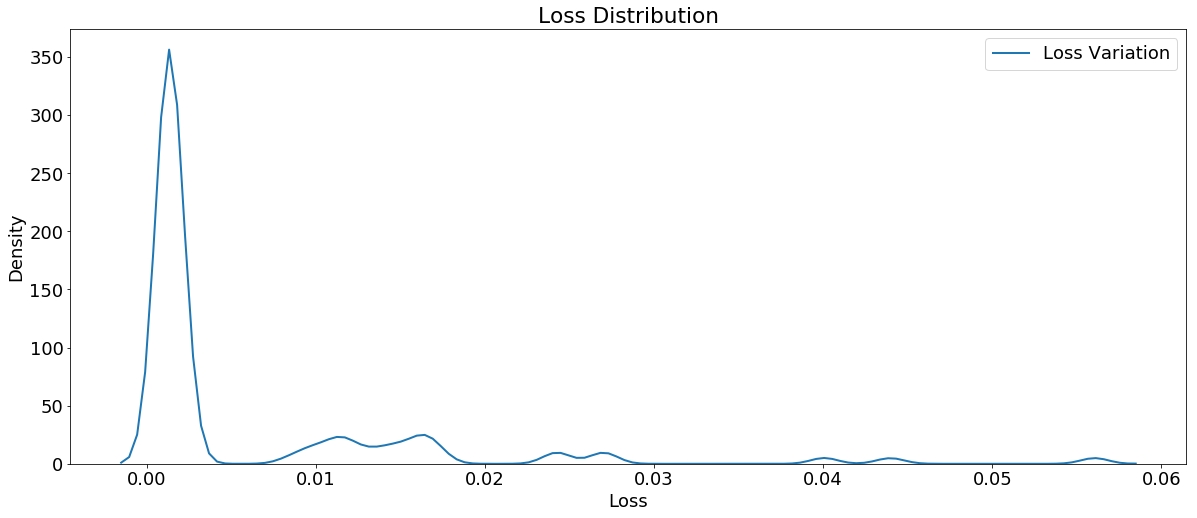

In [183]:
#os.chdir('./plots')
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(bayes_params['loss'], label = 'Loss Variation', linewidth = 2)
plt.legend()
plt.xlabel('Loss'); plt.ylabel('Density'); plt.title('Loss Distribution');
#plt.savefig(file_suffix+'_loss.png')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


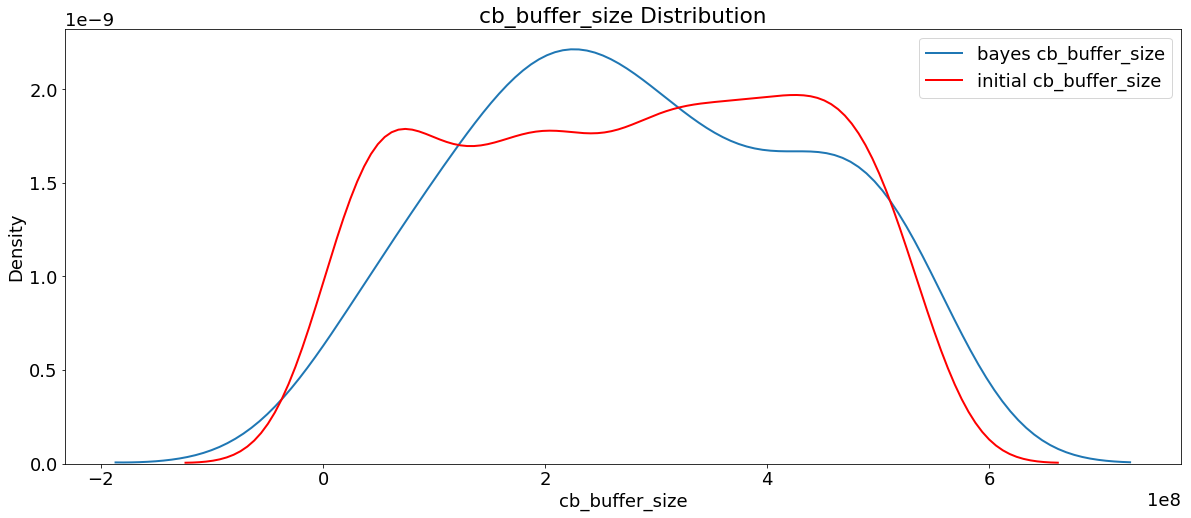

In [184]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18


sns.kdeplot(bayes_params['cb_buffer_size'], label = 'bayes cb_buffer_size', linewidth = 2)
sns.kdeplot(cb_buffer_size_dist,color="red",linewidth=2, label = 'initial cb_buffer_size')

plt.legend()
plt.xlabel('cb_buffer_size'); plt.ylabel('Density'); plt.title('cb_buffer_size Distribution');
#plt.savefig(file_suffix+'_cb_buffer_size.png')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


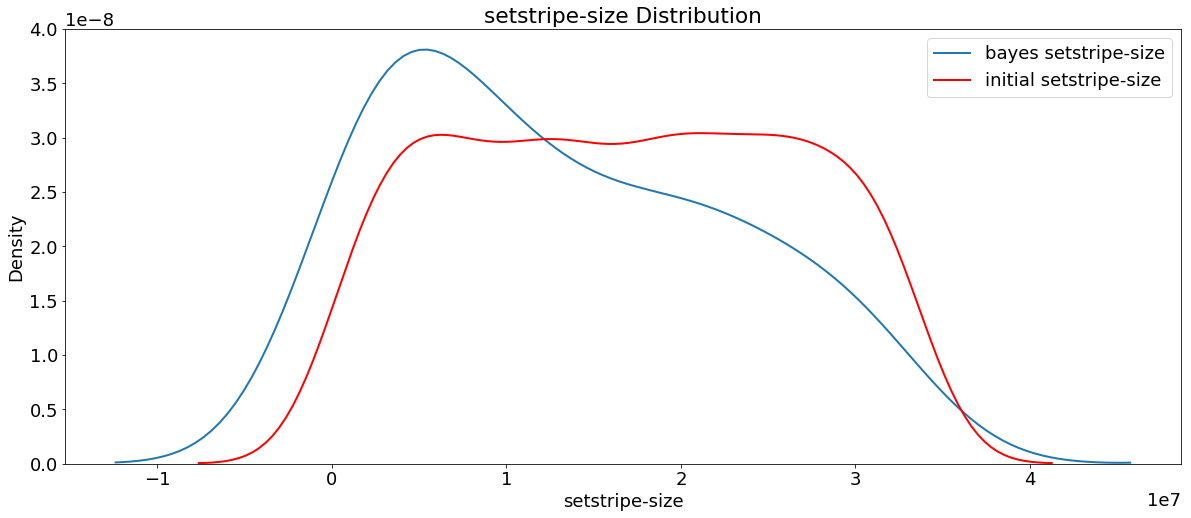

In [185]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-size'], label = 'bayes setstripe-size', linewidth = 2)
sns.kdeplot(setstripe_size_dist,color="red",linewidth=2, label = 'initial setstripe-size')

plt.legend()
plt.xlabel('setstripe-size'); plt.ylabel('Density'); plt.title('setstripe-size Distribution');
#plt.savefig(file_suffix+'_setstripe-size.png')

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


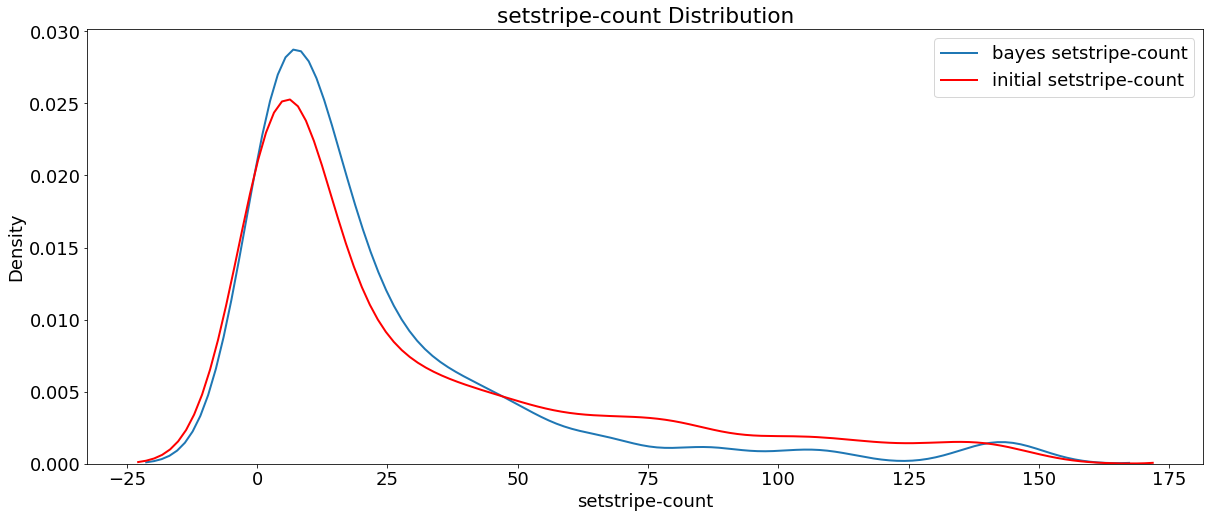

In [186]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(bayes_params['setstripe-count'], label = 'bayes setstripe-count', linewidth = 2)
sns.kdeplot(setstripe_count_dist,color="red",linewidth=2, label = 'initial setstripe-count')

plt.legend()
plt.xlabel('setstripe-count'); plt.ylabel('Density'); plt.title('setstripe-count Distribution');
#plt.savefig(file_suffix+'_setstripe-count.png')

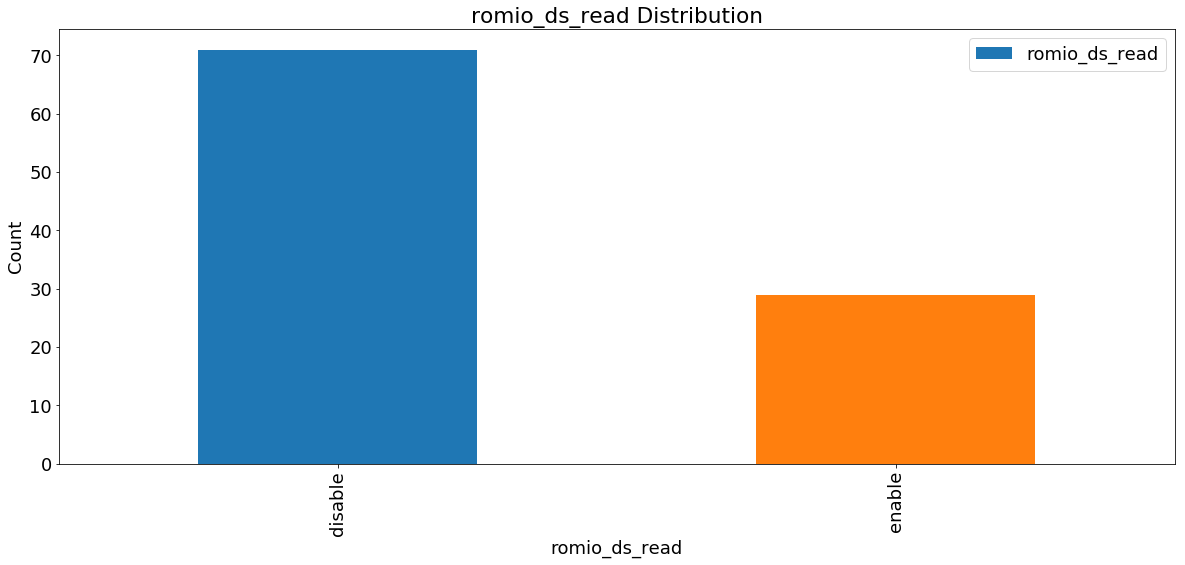

In [187]:
plt.figure(figsize = (20, 8))
from scipy.stats import itemfreq
plt.rcParams['font.size'] = 18
bayes_params['romio_ds_read'].value_counts().plot.bar()#plt.hist(romio_ds_read_dist,color="red",linewidth=2, label = 'initial romio_ds_read')

plt.legend()
plt.xlabel('romio_ds_read'); plt.ylabel('Count'); plt.title('romio_ds_read Distribution');
#plt.savefig(file_suffix+'_romio_ds_read.png')

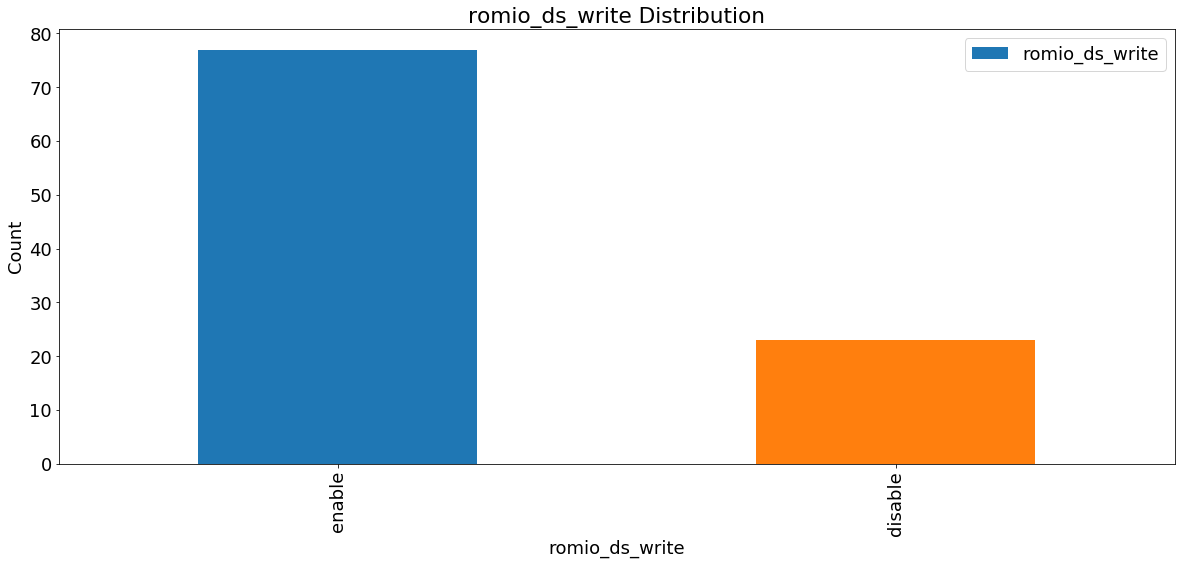

In [188]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

#plt.hist(bayes_params['romio_ds_write'], label = 'bayes romio_ds_write', linewidth = 2)
#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_ds_write')
bayes_params['romio_ds_write'].value_counts().plot.bar()
plt.legend()
plt.xlabel('romio_ds_write'); plt.ylabel('Count'); plt.title('romio_ds_write Distribution');
#plt.savefig(file_suffix+'_romio_ds_write.png')

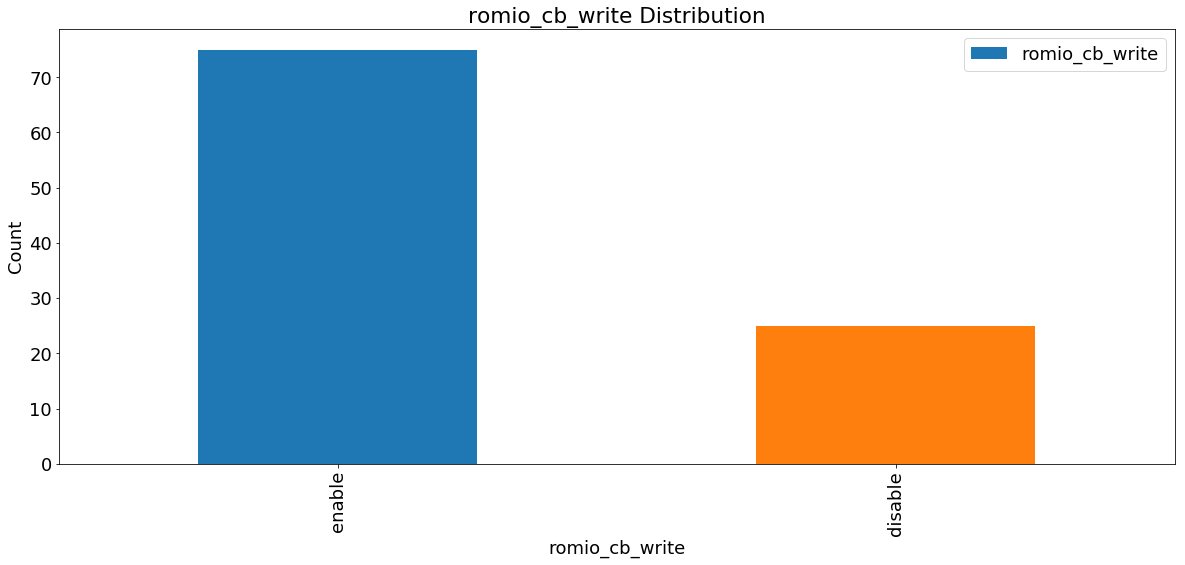

In [189]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_write'].value_counts().plot.bar()#plt.hist(romio_ds_write_dist,color="red",linewidth=2, label = 'initial romio_cb_write')

plt.legend()
plt.xlabel('romio_cb_write'); plt.ylabel('Count'); plt.title('romio_cb_write Distribution');
#plt.savefig(file_suffix+'_romio_cb_write.png')

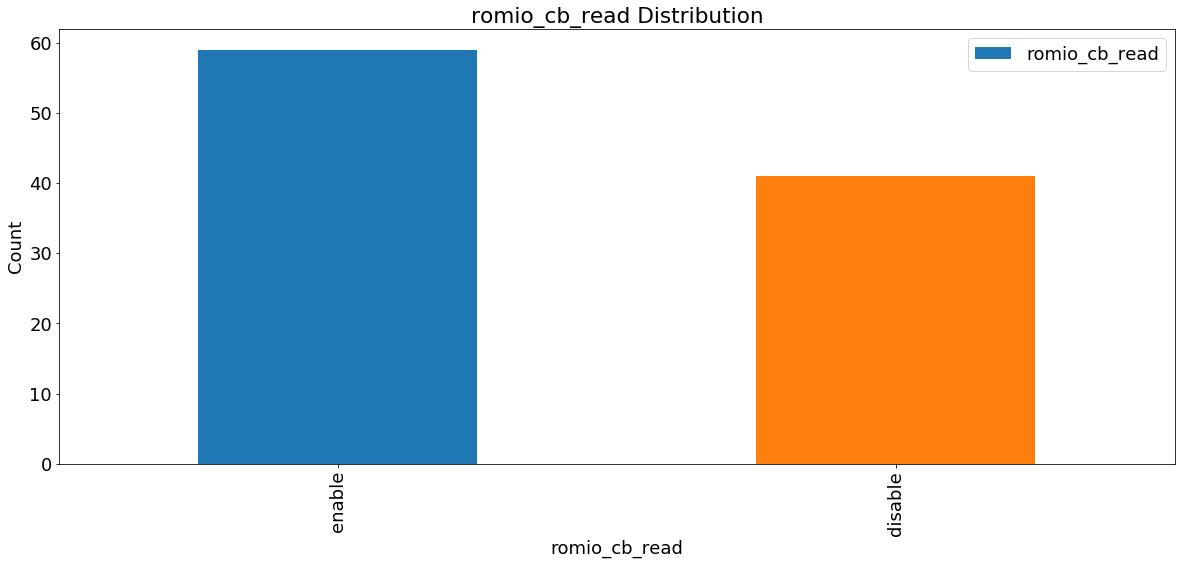

In [190]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

bayes_params['romio_cb_read'].value_counts().plot.bar()#plt.hist(romio_cb_read_dist,color="red",linewidth=2, label = 'initial romio_cb_read')

plt.legend()
plt.xlabel('romio_cb_read'); plt.ylabel('Count'); plt.title('romio_cb_read Distribution');
#plt.savefig(file_suffix+'_romio_cb_read.png')

In [84]:
os.chdir('../')